# ---START: Technical Requirements---


In [4]:
# in colab statsmodels is version 0.10.2
# you will need to run the following to update it to 0.13.2
# the recipe uses 0.13.2

#!pip install statsmodels -U

In [2]:
import statsmodels
statsmodels.__version__

'0.13.2'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller, 
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]  

In [2]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

**Check core library versions used in the recipe**
* if using **Colab** ensure the versions are the same. If needed to update use
```shell
!pip install <library_name> -U
```

In [5]:
import matplotlib 
import scipy 

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.1   
numpy -> 1.22.2
scipy -> 1.8.0
statsmodels -> 0.13.2



In [6]:
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [7]:
life.shape

(59, 1)

In [8]:
milk.shape

(168, 1)

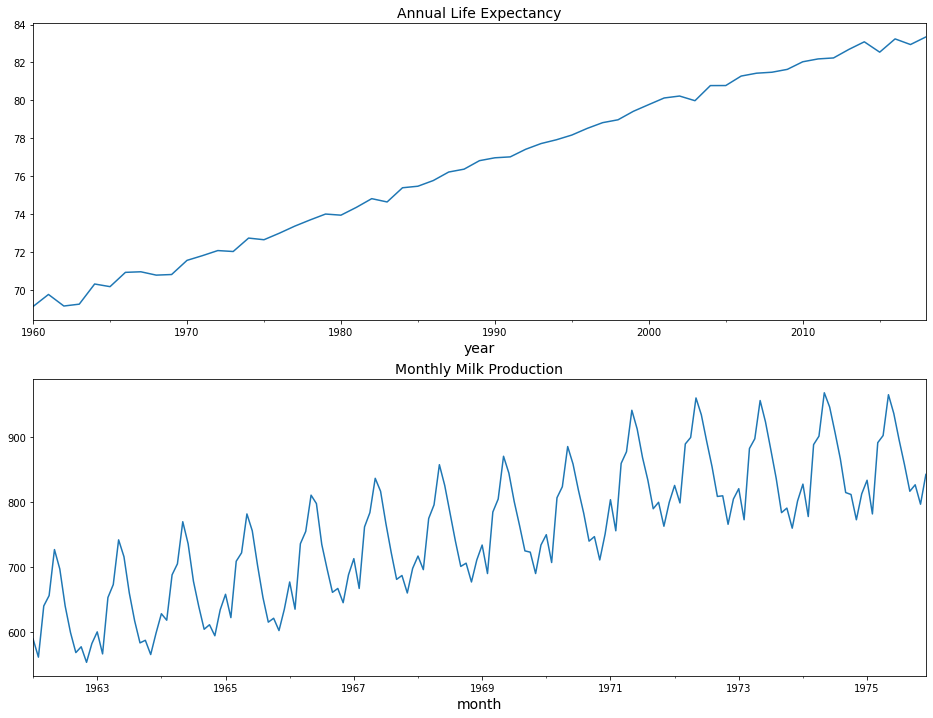

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy', 
                        legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', 
                        legend=False, ax=ax[1])

plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [10]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [11]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [12]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [13]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [14]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

In [15]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

# Plotting ACF and PACF

<AxesSubplot:xlabel='year'>

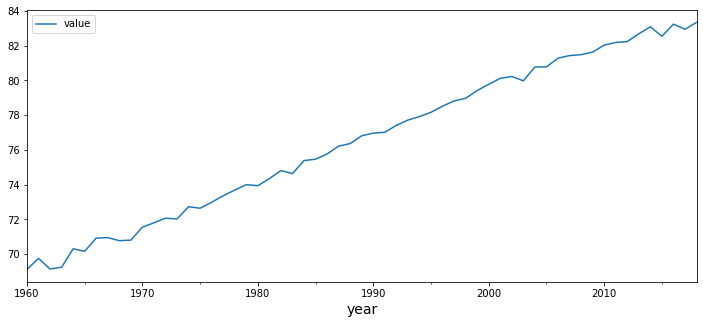

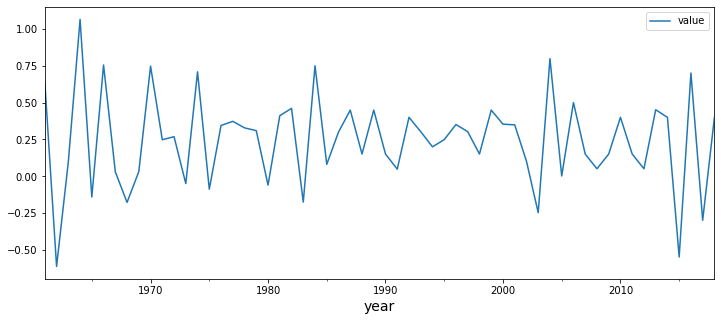

In [39]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [15]:
check_stationarity(life_diff)

'Stationary	 p-value:1.5562189676003248e-14 	 lags:1


('Stationary', 1.5562189676003248e-14)

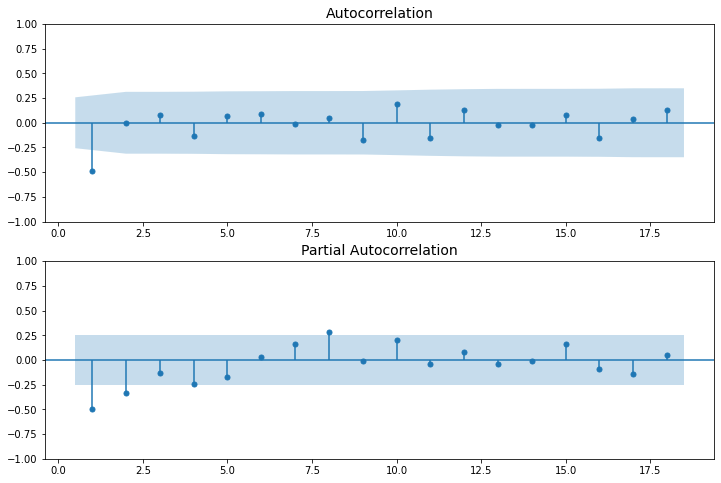

In [45]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:xlabel='month'>

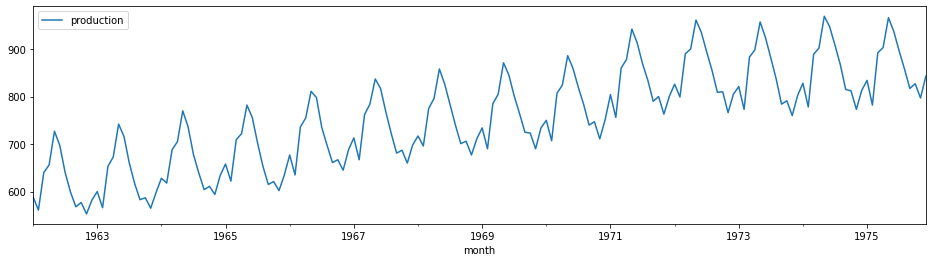

In [79]:
milk.plot()

In [46]:
milk_diff_12 = milk.diff(12).dropna()

In [47]:
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.16079880527711382 	 lags:12


('Non-Stationary', 0.16079880527711382)

In [48]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.865423431878876e-05 	 lags:11


('Stationary', 1.865423431878876e-05)

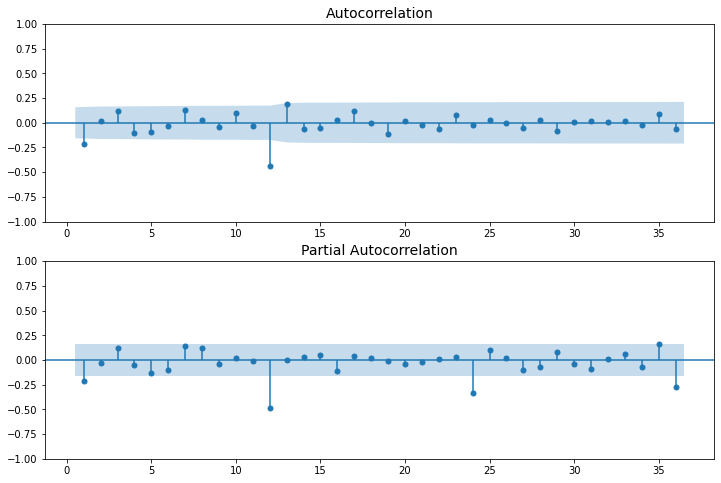

In [52]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()

### There is more

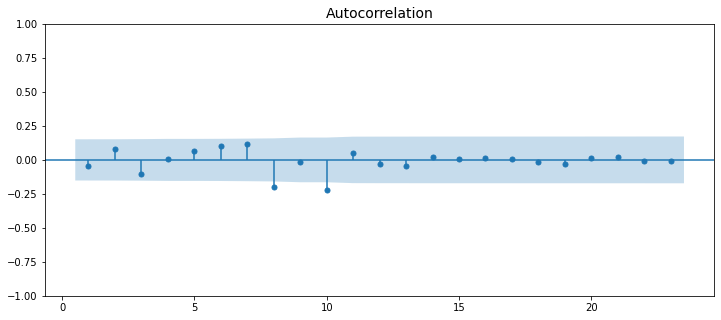

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
#plt.savefig('images/fig_10.4.png', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:xlabel='month'>

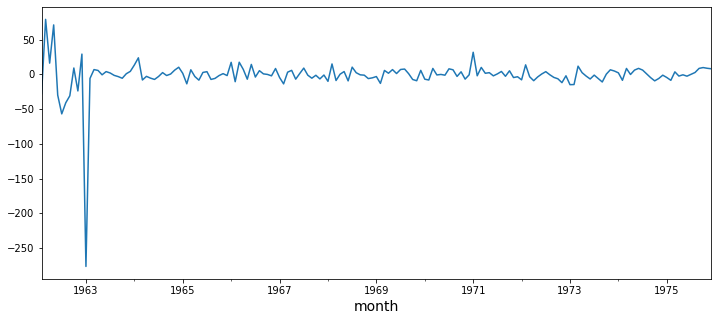

In [62]:
model.resid[1:].plot()

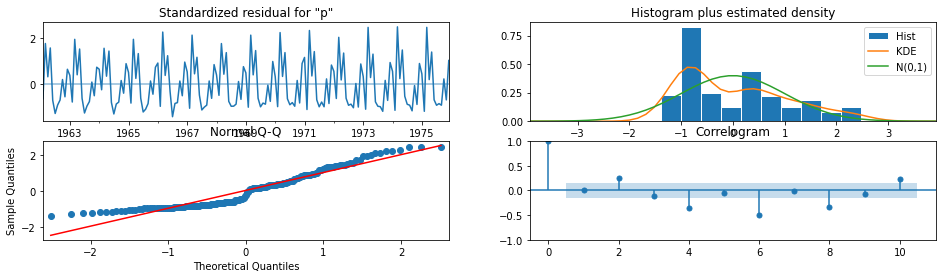

In [86]:
model.plot_diagnostics();

In [87]:
model.resid[1:]

month
1962-02-01   -28.018696
1962-03-01    79.433923
1962-04-01    14.769519
1962-05-01    70.771211
1962-06-01   -31.096291
                ...    
1975-08-01   -37.372077
1975-09-01   -40.421083
1975-10-01    10.626148
1975-11-01   -30.164606
1975-12-01    46.467269
Length: 167, dtype: float64

# Forecasting Univariate Time Series Data with Exponential Smoothing

In [65]:
from statsmodels.tsa.api import ExponentialSmoothing

In [66]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [77]:
train = life_train.values.ravel()
y = life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [86]:
life_best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: -137.03060180140557


In [79]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Mon, 11 Apr 2022"
Box-Cox:,False,Time:,06:15:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621952,alpha,True
smoothing_trend,0.1621952,beta,True


In [85]:
life_best_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162195,True
smoothing_trend,beta,0.162195,True
initial_level,l.0,68.748480,True
initial_trend,b.0,0.242227,True


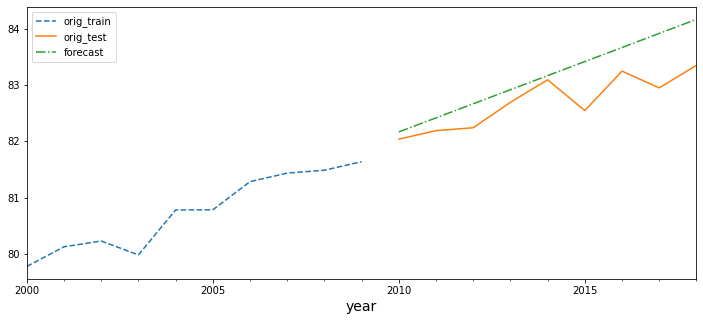

In [110]:
plot_forecast(life_best_model, '2000', life_train, life_test)
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [108]:
plot
plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

<Figure size 864x360 with 0 Axes>

In [114]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [115]:
len(milk_exp_comb)

24

In [116]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    milk_model_scores[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc': model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [118]:
milk_model = get_best_model(milk_model_scores)

Best model: 8 with lowest AIC score: 593.7138896839506


In [119]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Mon, 11 Apr 2022"
Box-Cox:,False,Time:,06:58:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


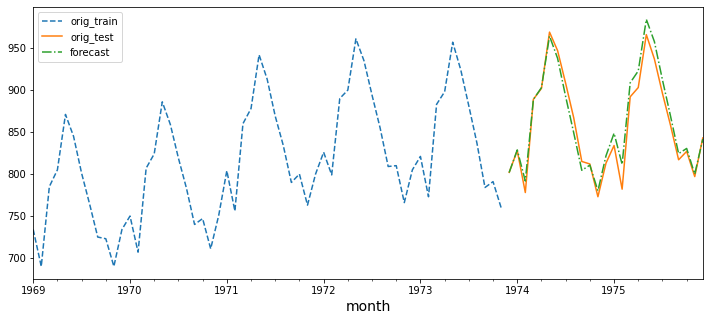

In [120]:
plot_forecast(milk_model, '1969', milk_train, milk_test)
# plt.savefig('images/fig_10.8.png', bbox_inches='tight', dpi=300)

## There is more

In [121]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

Importing plotly failed. Interactive plots will not work.


In [122]:
import darts
darts.__version__

'0.17.1'

In [123]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')
train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [124]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

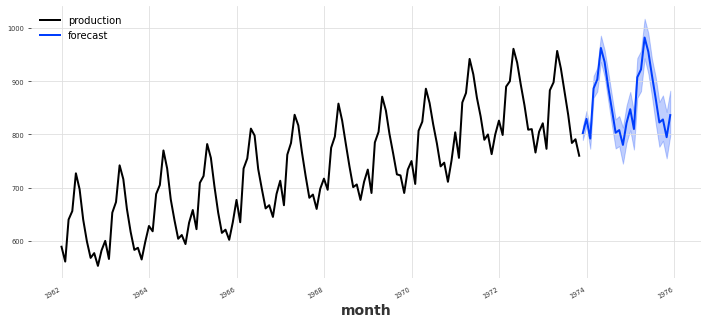

In [125]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.savefig('images/fig_10.9.png', bbox_inches='tight', dpi=300)

In [126]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Mon, 11 Apr 2022"
Box-Cox:,False,Time:,07:26:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


# Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [49]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]  

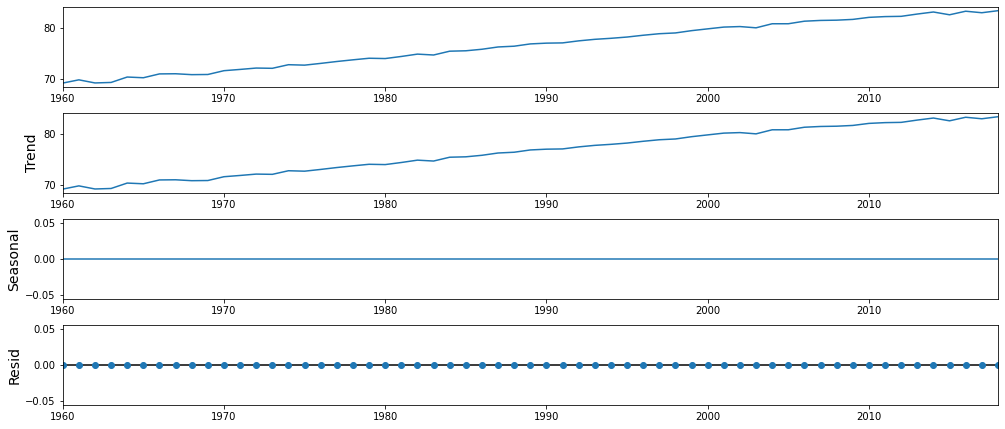

In [48]:
decomposed = seasonal_decompose(life)
decomposed.plot()
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)
plt.show()

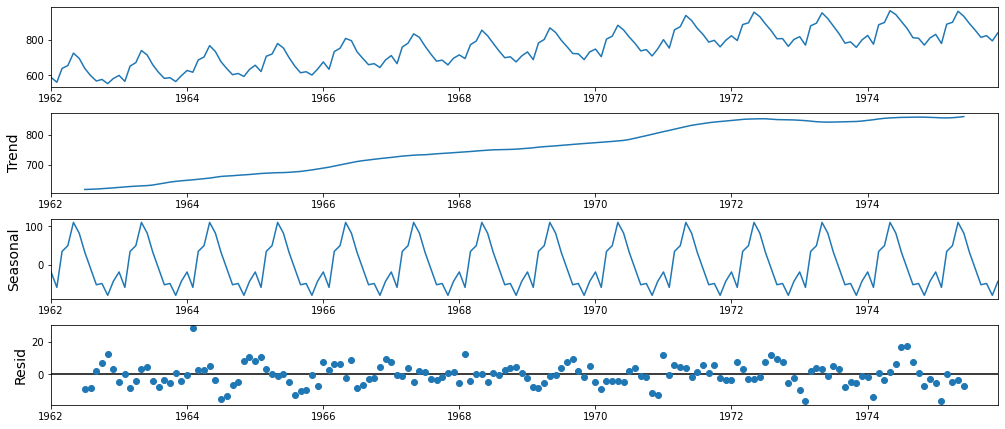

In [47]:
plt.rcParams["figure.figsize"] = [14, 6]  
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot(); plt.show()

In [39]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

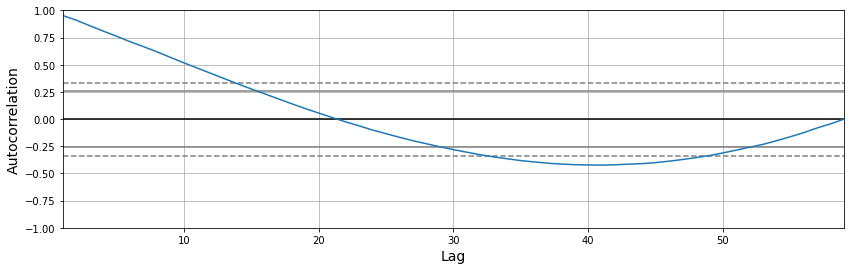

In [40]:
autocorrelation_plot(life)

In [41]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800043 	 lags:2


('Non-Stationary', 0.6420882853800043)

In [42]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.5562189676003248e-14 	 lags:1


('Stationary', 1.5562189676003248e-14)

<AxesSubplot:xlabel='year'>

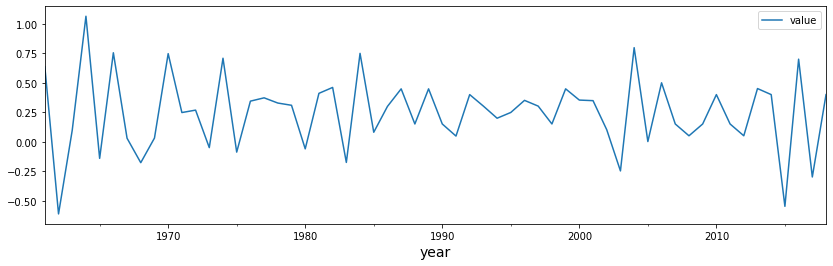

In [51]:
life_df1.plot()
#plt.savefig('images/fig_10.11.png', bbox_inches='tight', dpi=300)

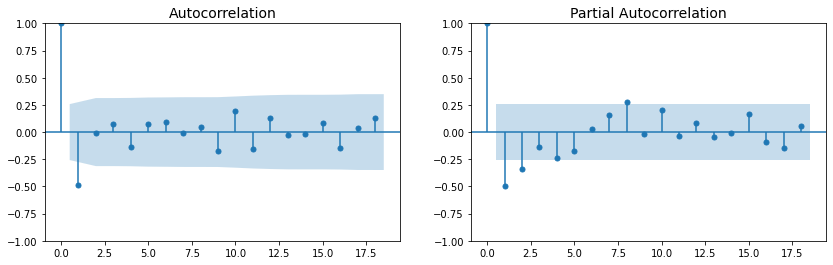

In [52]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1])
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)
plt.show()

In [145]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

24

In [54]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Mon, 11 Apr 2022   AIC                             52.321
Time:                        08:37:34   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

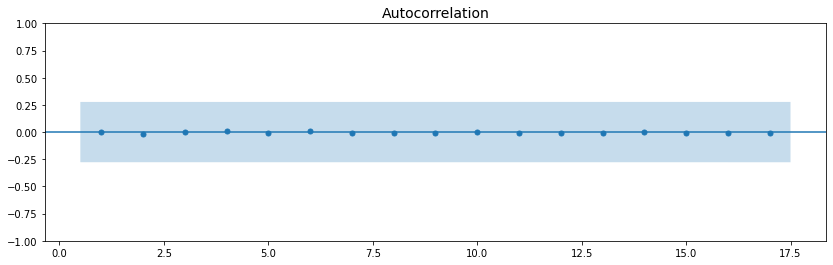

In [56]:
plot_acf(results.resid, zero=False);plt.show()

In [61]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

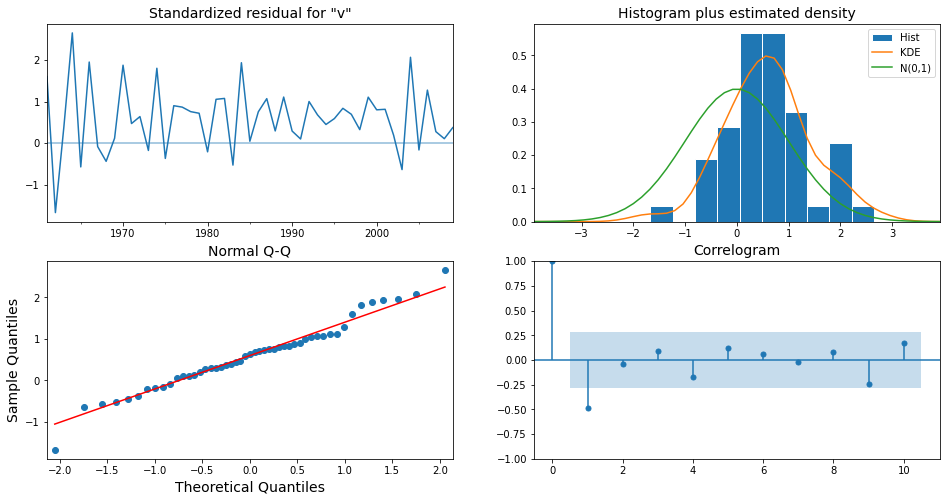

In [60]:
results.plot_diagnostics()
#plt.savefig('images/fig_10.15.png', bbox_inches='tight', dpi=300)
plt.show()

In [63]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [64]:
from scipy.stats import shapiro
shapiro(results.resid)[1] < 0.05

True

<AxesSubplot:xlabel='year'>

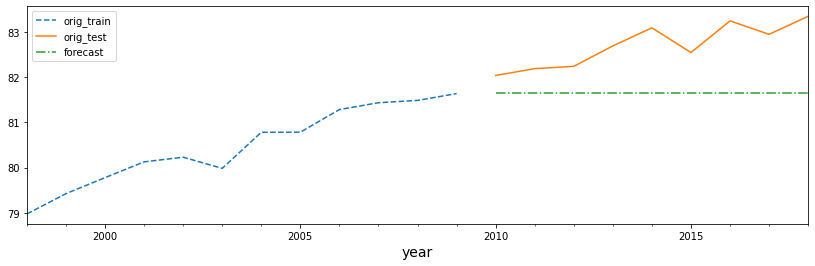

In [63]:
plot_forecast(results, '1998', life_train, life_test)

### There is more

In [134]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [135]:
get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.69747092367904


In [136]:
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.69747092367904


In [137]:
score[8]

{'order': (0, 2, 2),
 'AIC': 7.69747092367904,
 'BIC': 13.311073956402714,
 'AICc': 8.242925469133587,
 'RMSPE': 0.05595582928461146,
 'RMSE': 0.4635773476233591,
 'MAPE': 0.004494177136593728,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7fa92f2c5370>}

In [138]:
score[4]['model'].model_orders

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 1,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [95]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.697471,13.311074,8.242925,0.055956,0.463577,0.004494,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533201,17.100482,10.442292,0.054758,0.453636,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.675276,17.16008,10.605508,0.055728,0.461687,0.004469,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.510423,20.969525,12.905772,0.054477,0.451309,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.832574,23.188579,15.261146,0.074281,0.615756,0.006201,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.672789,27.157593,20.603021,0.054426,0.451322,0.003985,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.19374,28.807343,23.739194,0.048496,0.402102,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.293933,32.861214,26.203024,0.046797,0.387998,0.003499,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.316646,35.059048,31.583313,0.047356,0.392639,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.425771,39.101232,33.959104,0.043427,0.360003,0.003382,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [139]:
pd.DataFrame(score).T.sort_values(by='BIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.697471,13.311074,8.242925,0.055956,0.463577,0.004494,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533201,17.100482,10.442292,0.054758,0.453636,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.675276,17.16008,10.605508,0.055728,0.461687,0.004469,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.510423,20.969525,12.905772,0.054477,0.451309,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.832574,23.188579,15.261146,0.074281,0.615756,0.006201,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.672789,27.157593,20.603021,0.054426,0.451322,0.003985,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.19374,28.807343,23.739194,0.048496,0.402102,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.293933,32.861214,26.203024,0.046797,0.387998,0.003499,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.316646,35.059048,31.583313,0.047356,0.392639,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.425771,39.101232,33.959104,0.043427,0.360003,0.003382,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [81]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Mon, 11 Apr 2022   AIC                              7.697
Time:                        09:37:06   BIC                             13.311
Sample:                    01-01-1960   HQIC                             9.819
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9477    283.350     -0.007      0.995    -557.304     553.408
ma.L2          1.0000    290.943      0.003      0.997    -569.237     571.237
sigma2         0.0499     14.513      0.003      0.997     -28.394      28.494
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='year'>

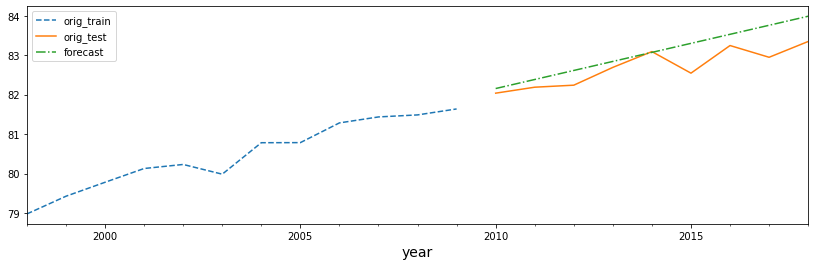

In [96]:
plot_forecast(best_m, '1998', life_train, life_test)

# Forecasting Univariate Time Series Data with Seasonal ARIMA

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]  

In [ ]:
SARIMAX(p)

<AxesSubplot:xlabel='month'>

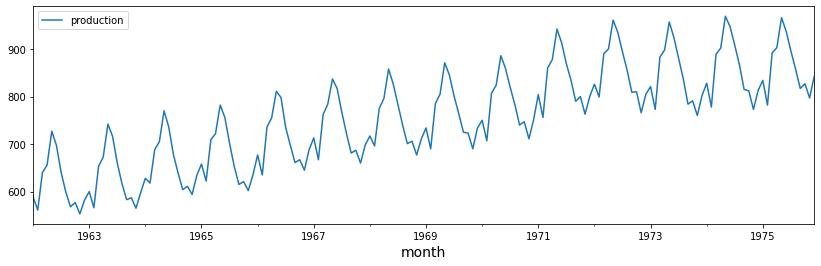

In [98]:
milk.plot()

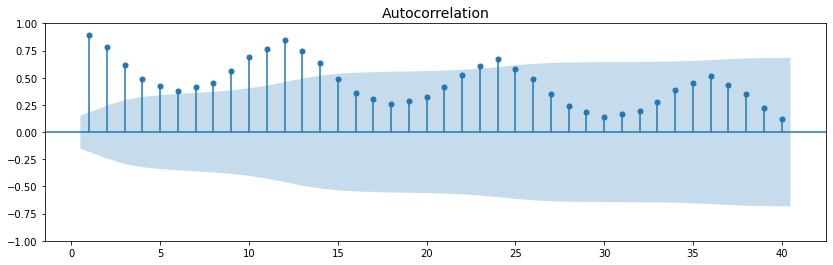

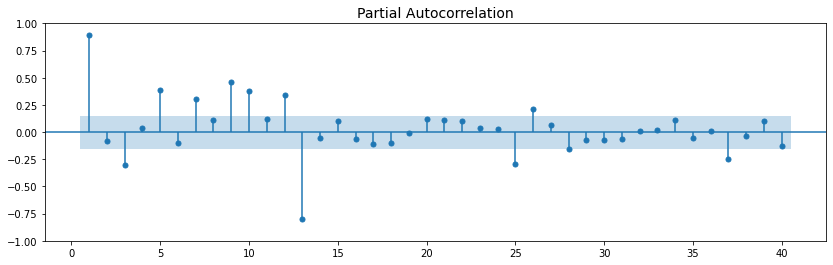

In [101]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

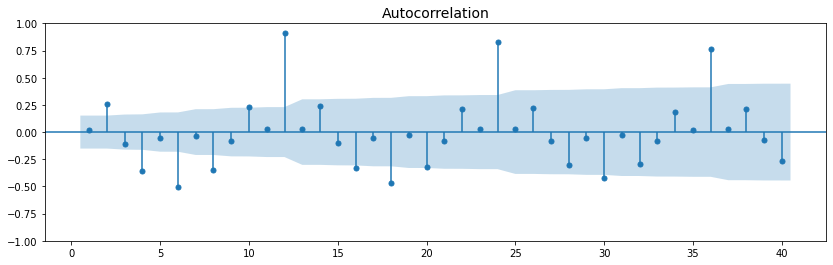

In [32]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); plt.show()

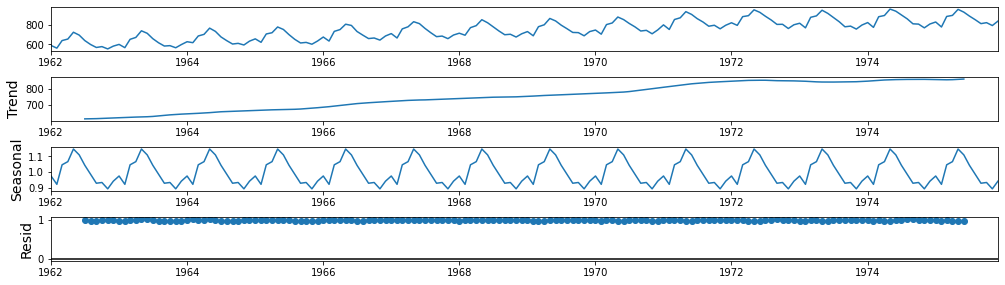

In [33]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); plt.show()

In [34]:
milk_s = decomposed.seasonal

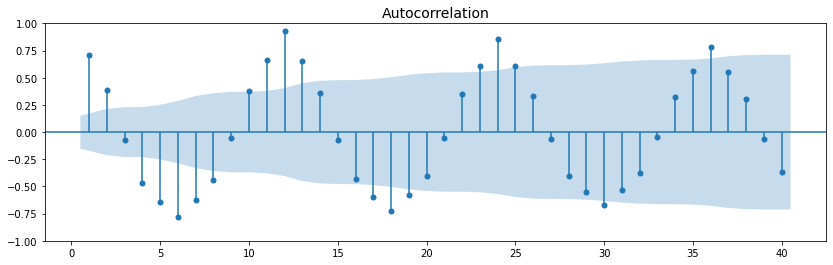

In [35]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [103]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

'Non-Stationary	 p-value:0.627426708603034 	 lags:13
'Non-Stationary	 p-value:0.16079880527711382 	 lags:12
'Stationary	 p-value:1.865423431878876e-05 	 lags:11


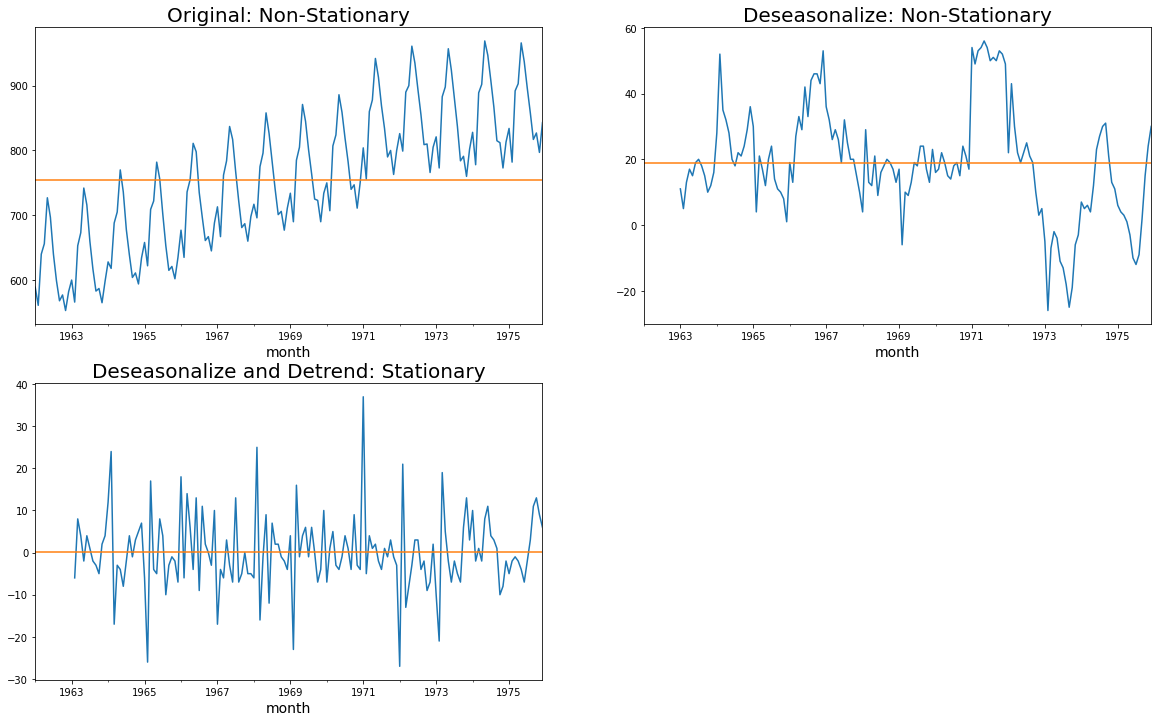

In [106]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

## Determine AR and MA terms

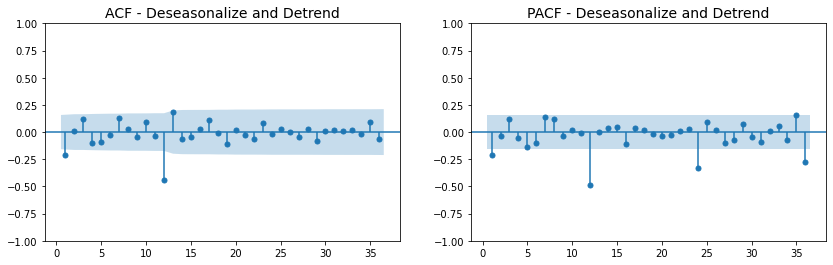

In [108]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

[1, 12, 24, 36, 48]


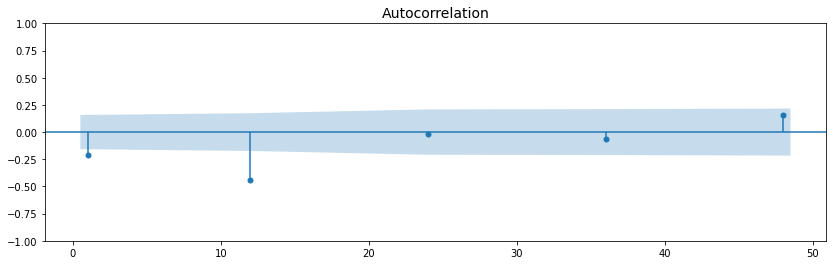

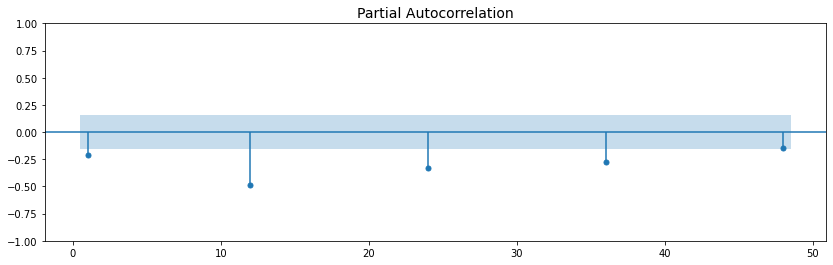

In [109]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

## Fitting a SARIMA Model

In [110]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

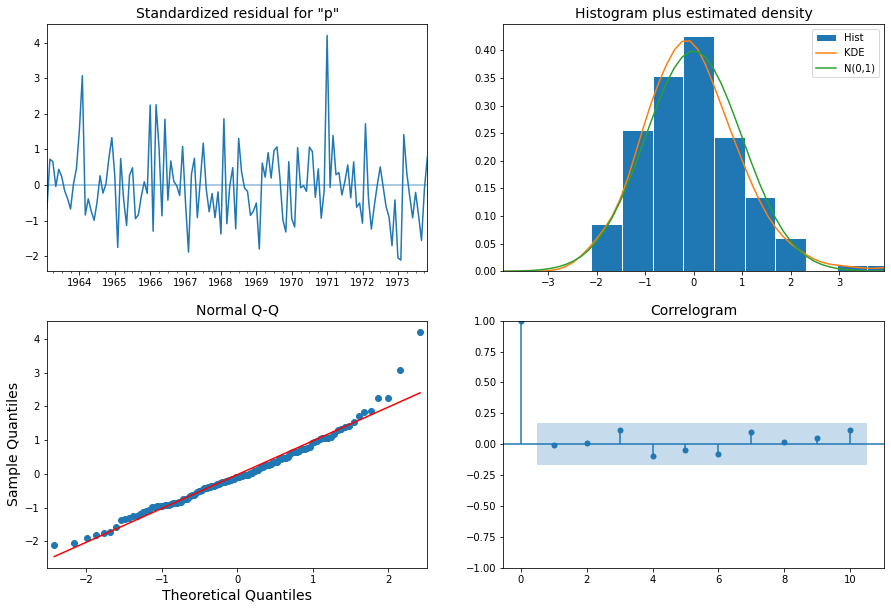

In [112]:
model.plot_diagnostics(figsize=(15,10))
plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)
plt.show()

In [113]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Mon, 11 Apr 2022   AIC                            903.335
Time:                                    10:43:09   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='month'>

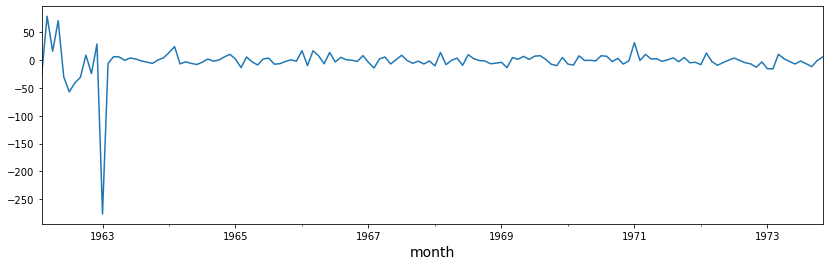

In [114]:
model.resid[1:].plot()

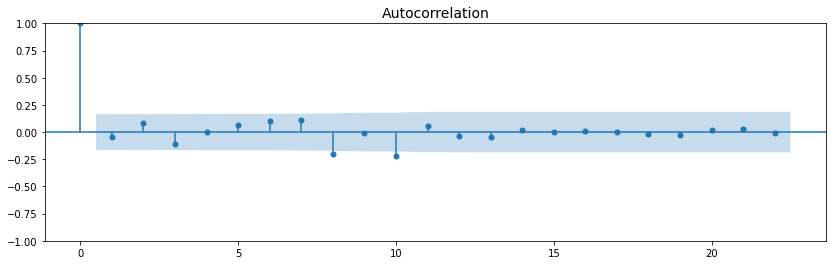

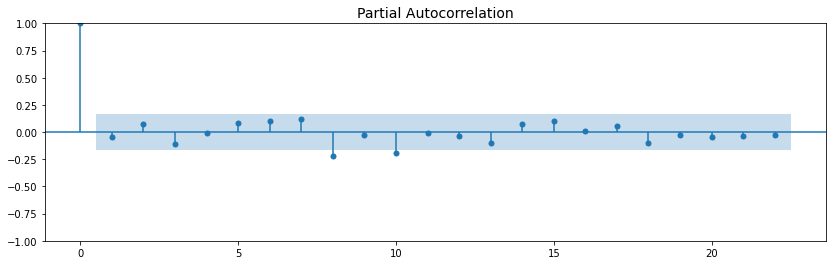

In [115]:
plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()

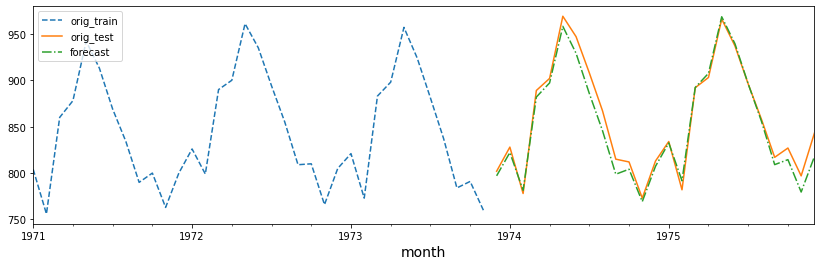

In [121]:
plot_forecast(model, '1971', milk_train, milk_test)
plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)

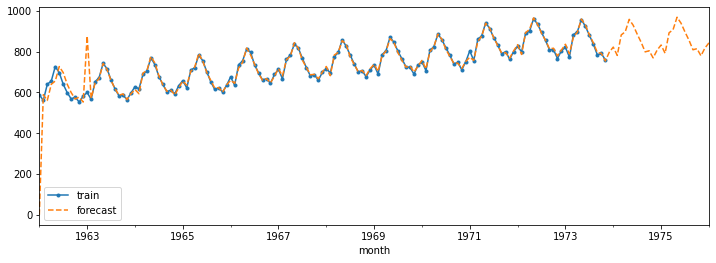

In [63]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

### There is more

In [122]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 1min 2s, sys: 2.58 s, total: 1min 5s
Wall time: 1min 8s


In [128]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.421765316976


In [131]:
results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135858,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328239,27.797121,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998608,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289727,24.535375,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,215,"(2, 2, 2)","(1, 1, 1)",797.357493,798.414097,816.510882,0.253439,21.463503,0.021407,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,191,"(2, 1, 2)","(1, 1, 1)",797.407854,798.454583,816.622379,0.11154,9.5933,0.009061,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611921,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188642,812.362843,0.133004,11.39597,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427703,36.196,0.036861,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [133]:
results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328239,27.797121,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.13409,11.489677,0.01037,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289727,24.535375,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135858,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611921,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188642,812.362843,0.133004,11.39597,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427703,36.196,0.036861,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998608,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,131,"(1, 2, 1)","(0, 1, 1)",802.770371,803.134007,813.750099,0.205807,17.449652,0.016939,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [85]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.421765316976,
 'AICc': 796.206812045948,
 'BIC': 811.838956007343,
 'RMSPE': 0.17818985654535582,
 'RMSE': 15.135857809208446,
 'MAPE': 0.014454257995644617,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f775d6e0ee0>}

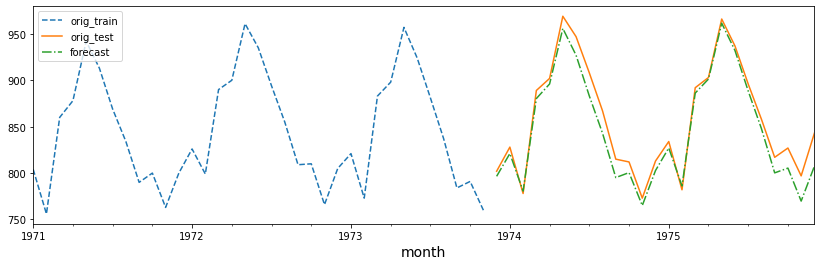

In [129]:
plot_forecast(best_model, '1971', milk_train, milk_test)
plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)